In [1]:
#import require python classes and packages
import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Convolution2D
from keras.models import Sequential, load_model, Model
import pickle
from keras.applications import ResNet50#load resnet 50 as transfer learning
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras_applications.resnext import ResNeXt50 #load resnext50 as propose transfer learning
import keras
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

Using TensorFlow backend.
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [12]:
#define dataset path and extract labels
path = "LandingDataset"
labels = []
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())
print("Landing Scenes 7 Dataset Class Labels : "+str(labels))            

Landing Scenes 7 Dataset Class Labels : ['Building', 'Field', 'Lawn', 'Mountain', 'Road', 'Vehicles', 'WaterArea', 'Wilderness']


In [13]:
#function to get class label from given image
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

In [14]:
#load dataset images
if os.path.exists('model/X.txt.npy'): #load dataset from processed models
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else: #dataset not processed then read and save and load
    X = []
    Y = []
    for root, dirs, directory in os.walk(path): #loop all dataset images
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read image
                img = cv2.resize(img, (32,32))#resize image
                X.append(img) #add image features to training X
                label = getLabel(name) #get image label
                Y.append(label) #add label to Y array
    X = np.asarray(X)
    Y = np.asarray(Y)
    np.save('model/X.txt',X)#save processed images
    np.save('model/Y.txt',Y)                    
unique, count = np.unique(Y, return_counts=True)   
print("Dataset loading task completed")
print("Total images found in dataset : "+str(X.shape[0]))

Dataset loading task completed
Total images found in dataset : 2573


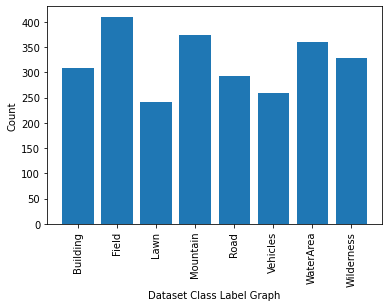

In [15]:
#plot graph of various class label images and its count
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

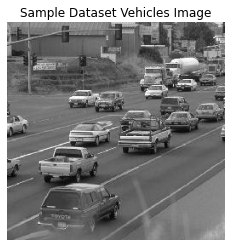

In [16]:
#display sample dataset images of vehicles
no_fire = cv2.imread("LandingDataset/Vehicles/1982.jpg")
plt.imshow(no_fire)
plt.title('Sample Dataset Vehicles Image')
plt.axis('off')
plt.show()

In [17]:
#dataset preprocess such as shuffling and normalization
X = X.astype('float32')
X = X/255 #normalizing image training features
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
print("Dataset Processing Completed")

Dataset Processing Completed


In [18]:
#now splitting dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 2058
Testing Size (20%): 515



In [19]:
precision = []
recall = []
fscore = []
accuracy = []

In [20]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.xticks(rotation=90)
    plt.show()









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Propose ResNext50 with ADAM Accuracy  : 97.86407766990291
Propose ResNext50 with ADAM Precision   : 98.144130134554
Propose ResNext50 with ADAM Recall      : 97.61838279615644
Propose ResNext50 with ADAM FMeasure    : 97.84247670262407


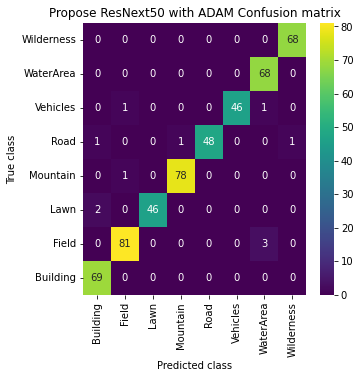

In [21]:
#now train Propose ResNext50 algorithm by using CNN and ADAM optimizers
#create ResNext%0 object
resnext = ResNeXt50(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), backend = keras.backend,
                layers = keras.layers, models = keras.models, utils = keras.utils)
for layer in resnext.layers:
    layer.trainable = False
#define object for CNN 
resnext_model = Sequential()
#add resnext to cnn object
resnext_model.add(resnext)
#define CNN layers with input shape and 32 neuron for features filtration
resnext_model.add(Convolution2D(32, (1 , 1), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
#max pool layer to collect filtered features
resnext_model.add(MaxPooling2D(pool_size = (1, 1)))
#define another layer
resnext_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
resnext_model.add(MaxPooling2D(pool_size = (1, 1)))
resnext_model.add(Flatten())
resnext_model.add(Dense(units = 256, activation = 'relu'))
#define output layers which help in predicting output with threhsold probability
resnext_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compile and train model
resnext_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/resnext_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/resnext_weights.hdf5', verbose = 1, save_best_only = True)
    hist = resnext_model.fit(X_train, y_train, batch_size = 32, epochs = 30, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/resnext_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    resnext_model = load_model("model/resnext_weights.hdf5")
#perform prediction on test data   
predict = resnext_model.predict(X_test)
predict = np.argmax(predict, axis=1)
test = np.argmax(y_test, axis=1)
calculateMetrics("Propose ResNext50 with ADAM", predict, test)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Existing ResNet50 with ADAM Accuracy  : 40.3883495145631
Existing ResNet50 with ADAM Precision   : 27.579237331266448
Existing ResNet50 with ADAM Recall      : 42.012457672942595
Existing ResNet50 with ADAM FMeasure    : 31.42255385338808


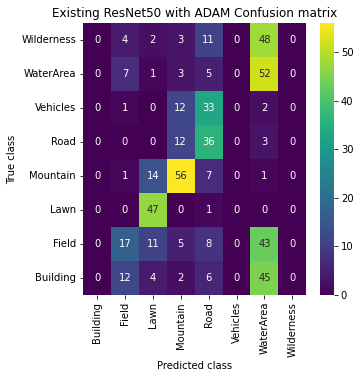

In [22]:
#now train ResNet50 as existing algorithm
#define resnet50 object
resnet = ResNet50(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
resnet_model = Sequential()
#add resnet50 object to CNN as tranfer learning
resnet_model.add(resnet)
#define parameters for transfer learning
resnet_model.add(GlobalAveragePooling2D())
resnet_model.add(Dense(2, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.2))
#define prediction output layer
resnet_model.add(Dense(y_train.shape[1], activation='sigmoid'))
#compile and train the model
resnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/resnet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/resnet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = resnet_model.fit(X_train, y_train, batch_size = 32, epochs = 30, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/resnet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    resnet_model = load_model("model/resnet_weights.hdf5")
#perform prediction on test data using resnet tranfer learning model   
predict = resnet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
test = np.argmax(y_test, axis=1)
calculateMetrics("Existing ResNet50 with ADAM", predict, test)


Extension Hybrid Ensemble Random Forest Accuracy  : 100.0
Extension Hybrid Ensemble Random Forest Precision   : 100.0
Extension Hybrid Ensemble Random Forest Recall      : 100.0
Extension Hybrid Ensemble Random Forest FMeasure    : 100.0


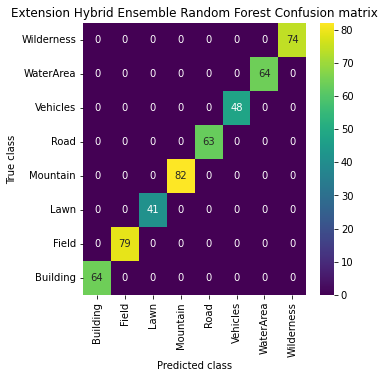

In [23]:
#now train hybrid ensemble random forest algorithm as extension by extracting features from trained ResNext50 model and then
#retrain extracted features using Random Forest to build hybrid ensemble model and then comprae its accuracy with propose model
ensemble_model = Model(resnext_model.inputs, resnext_model.layers[-2].output)#creating hybrid model object using ResNext
ensemble_features = ensemble_model.predict(X)  #extracting ResNext features from dataset X
Y = np.argmax(Y, axis=1)
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(ensemble_features, Y, test_size=0.2) #split dataset into train and test
#now train random forest on hybrid features
rf = RandomForestClassifier()
rf.fit(ensemble_features, Y)
#perform prediction on test data
predict = rf.predict(X_test)
calculateMetrics("Extension Hybrid Ensemble Random Forest", predict, y_test)

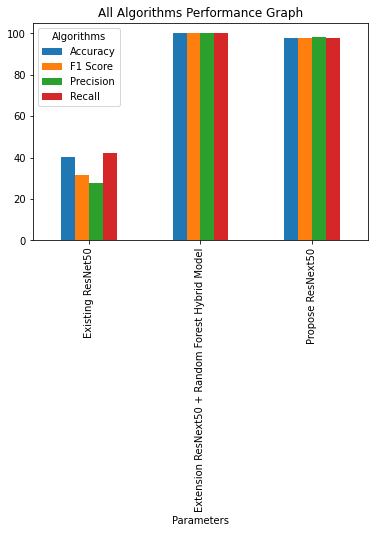

In [24]:
df = pd.DataFrame([['Existing ResNet50','Precision',precision[1]],['Existing ResNet50','Recall',recall[1]],['Existing ResNet50','F1 Score',fscore[1]],['Existing ResNet50','Accuracy',accuracy[1]],
                   ['Propose ResNext50','Precision',precision[0]],['Propose ResNext50','Recall',recall[0]],['Propose ResNext50','F1 Score',fscore[0]],['Propose ResNext50','Accuracy',accuracy[0]],
                   ['Extension ResNext50 + Random Forest Hybrid Model','Precision',precision[2]],['Extension ResNext50 + Random Forest Hybrid Model','Recall',recall[2]],['Extension ResNext50 + Random Forest Hybrid Model','F1 Score',fscore[2]],['Extension ResNext50 + Random Forest Hybrid Model','Accuracy',accuracy[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar')
plt.title("All Algorithms Performance Graph")
plt.show()

In [25]:
#showing all algorithms with scenario A and B performance values
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["Existing ResNet50 Adam","Propose ResNext50 Adam", "Extension ResNext50 + Random Forest Hybrid Model"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,Existing ResNet50 Adam,98.144130,97.618383,97.842477,97.864078
1,Propose ResNext50 Adam,27.579237,42.012458,31.422554,40.388350
2,Extension ResNext50 + Random Forest Hybrid Model,100.000000,100.000000,100.000000,100.000000


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  # Remove the CWD from sys.path while we load stuff.
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()


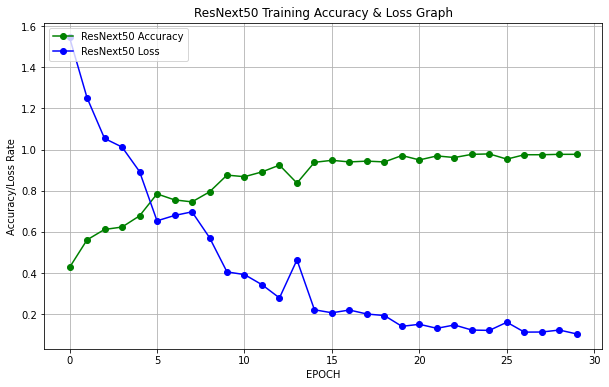

In [50]:
f = open('model/resnext_history.pckl', 'rb')
data = pickle.load(f)
f.close()
accuracy = data['val_acc']
loss = data['val_loss']
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy/Loss Rate')
plt.plot(accuracy, 'ro-', color = 'green')
plt.plot(loss, 'ro-', color = 'blue')
plt.legend(['ResNext50 Accuracy', 'ResNext50 Loss'], loc='upper left')
plt.title('ResNext50 Training Accuracy & Loss Graph')
plt.show()

In [38]:
def predictLanding(testImage):
    image = cv2.imread(testImage)
    img = cv2.resize(image, (32,32))
    im2arr = img.reshape(1,32,32,3)
    img = np.asarray(im2arr)
    img = img.astype('float32')
    img = img/255 #normalizing test image
    features = ensemble_model.predict(img) #using ensemble ResNext50 model we are extracting features from given image
    predict = rf.predict(features)
    predict = predict[0]
    img = cv2.imread(testImage)
    img = cv2.resize(img, (600,400))
    cv2.putText(img, 'Landing Predicted As : '+labels[predict], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

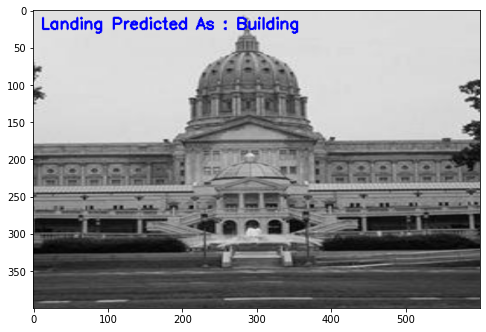

In [39]:
predictLanding("testImages/1.jpg")

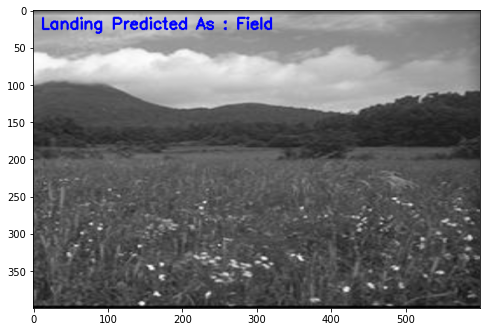

In [40]:
predictLanding("testImages/2.jpg")

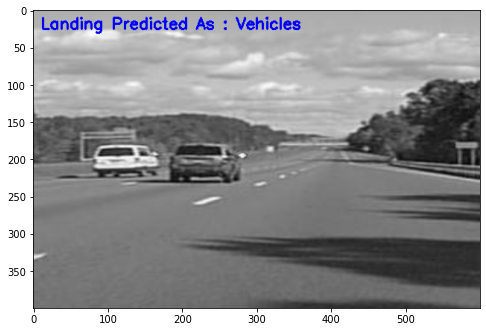

In [41]:
predictLanding("testImages/7.jpg")

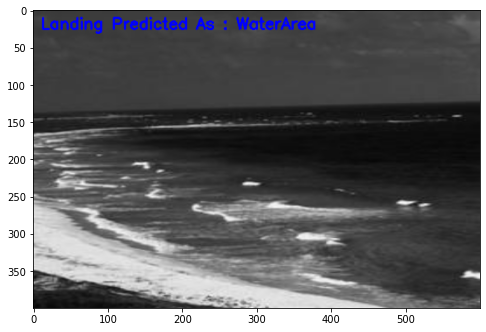

In [42]:
predictLanding("testImages/8.jpg")

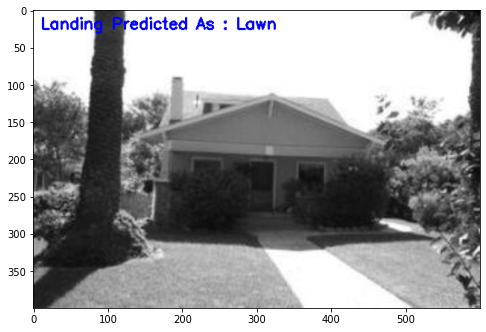

In [43]:
predictLanding("testImages/3.jpg")